# ネットワーク伝播

In [123]:
import numpy as np
import pandas as pd
import networkx as nx
import sklearn
from scipy import cluster


import matplotlib.pyplot as plt
import seaborn as sns

## ネットワークの読み込み
空手クラブネットワークを例にする。



In [13]:
G = nx.karate_club_graph()

In [62]:
faction = [G.nodes[i]["club"] for i in range(len(G.nodes()))]

## 実際のラベルを格納


In [106]:
label_real = [-1 if x == "Mr. Hi" else 1 for x in faction]

## 隣接行列の正規化
繰り返し計算を収束させるために。どちらかを使う。

In [107]:
mtx = nx.adjacency_matrix(G).toarray()
d = np.array([d for n, d in G.degree()])

mtx = mtx / np.sqrt(d@d.T)
Wij = mtx.T

## ラベル予測
Leave-one-out検証

In [113]:
alpha = 0.8
label_pred = []
for i in range(G.number_of_nodes()):
    x = np.array(label_real, dtype=np.float)
    x[i] = 0

    x0 = x
    while(1):
        x_pred = x
        x = (1 - alpha) * Wij@x + alpha * x0
        if (np.linalg.norm((x - x_pred), ord=1) < 1e-6):
            break
    label_pred.append(x[i])

<ipython-input-113-44d9569544ce>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(label_real, dtype=np.float)


In [114]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(label_real, label_pred)
auc = sklearn.metrics.roc_auc_score(label_real, label_pred)


Text(0.5, 1.0, 'AUC = 0.9930795847750865')

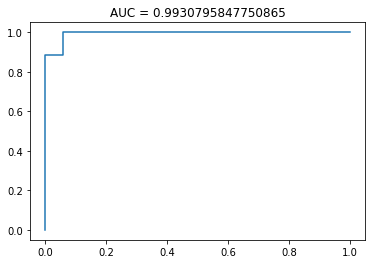

In [115]:
plt.plot(fpr, tpr)
plt.title(F"AUC = {auc}")

## ネットワークを表示
ノードの色が予測ラベル、形が実際のラベルを表す。


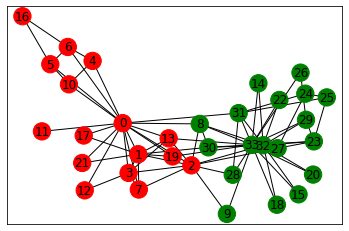

In [116]:
label_pred_idx = ["red" if x < 0 else "green" for x in label_pred]
nx.draw_networkx(G, node_color=label_pred_idx)

## ネットワーククラスタリング
ネットワーク伝播

In [117]:
alpha = 0.4
x = np.zeros((G.number_of_nodes(), G.number_of_nodes()))
np.fill_diagonal(x, 1)

x0 = x
while(1):
    x_pred = x
    x = (1 - alpha) * Wij@x + alpha * x0
    if (np.linalg.norm((x - x_pred), ord=1) < 1e-6):
        break


In [133]:
# my_palette = dict(zip(df.cyl.unique(), ["orange","yellow","brown"]))
# row_colors = df.cyl.map(my_palette)
# sns.clustermap(x, metric="correlation", cmap="Blues", standard_scale=1)

## クラタス2個とした場合の分割
ノードの色が予測ラベル、形が実際のラベルを表す。

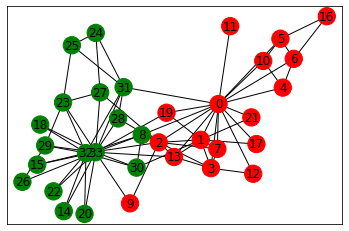

In [131]:
Z = cluster.hierarchy.ward(x)
utree = cluster.hierarchy.cut_tree(Z, n_clusters=2)
label_pred_idx = ["red" if x == 0 else "green" for x in utree]
nx.draw_networkx(G, node_color=label_pred_idx)